# **ResNet50 for Knee X-Ray Classification**

In this notebook, we develop and train a ResNet50 model for multi-class classification of knee X-ray images. The images are categorized into five classes based on the Kellgren-Lawrence grading scale, which evaluates the severity of knee osteoarthritis.

We use a [dataset](https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity) from Kaggle, which provides a collection of knee X-ray images. The notebook will cover the data preprocessing steps, model training, and evaluation processes to assess the performance of the ResNet50 model. Additionally, we will analyze the results to understand how well the model distinguishes between different grades of osteoarthritis.

## **Data Pre-processing**



Data preprocessing is essential for preparing raw data for analysis and model training. It involves cleaning, transforming, and organizing the data to enhance model performance. Below, we detail all the preprocessing steps performed.

### **Importing Essential Libraries**




Initially, we import all the necessary libraries used throughout the notebook for analysis and model training.

In [1]:
import glob
import os
import cv2
import numpy as np
import shutil
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from operator import itemgetter
import tensorflow as tf

from google.colab import files

### **Utility Functions**

We define several utility functions to facilitate data processing and model training. These functions help automate repetitive tasks and ensure code consistency throughout the notebook.

In [2]:
def moveImgs(images, grade, path_dst):
  img_paths = glob.glob(f'/content/DatasetKneeKL/{grade}/*.png')
  imgs = itemgetter(*images)(img_paths)
  for img in imgs:
    #print(f'Copio {img} in {path_dst}')
    shutil.move(img, path_dst)

def countImages(path):
  cont = [0]*5

  # Calculate the number of photos for each grade.
  for grades in range(5):
    cont[grades] = len(glob.glob(path + f'{grades}/*.png'))

  return cont

def selectRandomImgs(side):
  selected_imgs = []

  # Given the side (L or R), find an image for each grade.
  for grades in range(5):
    images = glob.glob(f"/content/KneeKL224/train/{grades}/*.png")
    filtered_imgs = [i for i in images if side in os.path.basename(i)]
    random_img = random.choice(filtered_imgs)
    selected_imgs.append(random_img)

  return selected_imgs

def drawHist(grades):
  plt.bar([f'Grade {g}' for g in range(5)], grades)
  plt.title('Number of Images per KL Grade')
  plt.xlabel('Kellgren-Lawrence Grade')
  plt.ylabel('Number of Images')
  plt.show()

### **Downloading the dataset**

We download the dataset directly from Kaggle. This step involves using Kaggle’s API to download the dataset locally.

In [3]:
from google.colab import files
!pip install kaggle > /dev/null

# Dataset Download (https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity)
!kaggle datasets download -d shashwatwork/knee-osteoarthritis-dataset-with-severity

# Creating the 'KneeKL224' folder and unzipping the dataset into this folder
!mkdir -p KneeKL224
!unzip knee-osteoarthritis-dataset-with-severity.zip -d KneeKL224 > /dev/null

# Removing the .zip file
!rm knee-osteoarthritis-dataset-with-severity.zip

Dataset URL: https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity
License(s): Attribution 4.0 International (CC BY 4.0)
100% 204M/204M [00:11<00:00, 20.5MB/s]
100% 204M/204M [00:11<00:00, 18.4MB/s]


### **Dataset structure**

We examine the structure of the dataset to understand its organization and contents.

The dataset contains knee X-ray images organized by the five grades of the Kellgren-Lawrence (KL) scale. elow, a visual comparison of the five KL grades is provided.

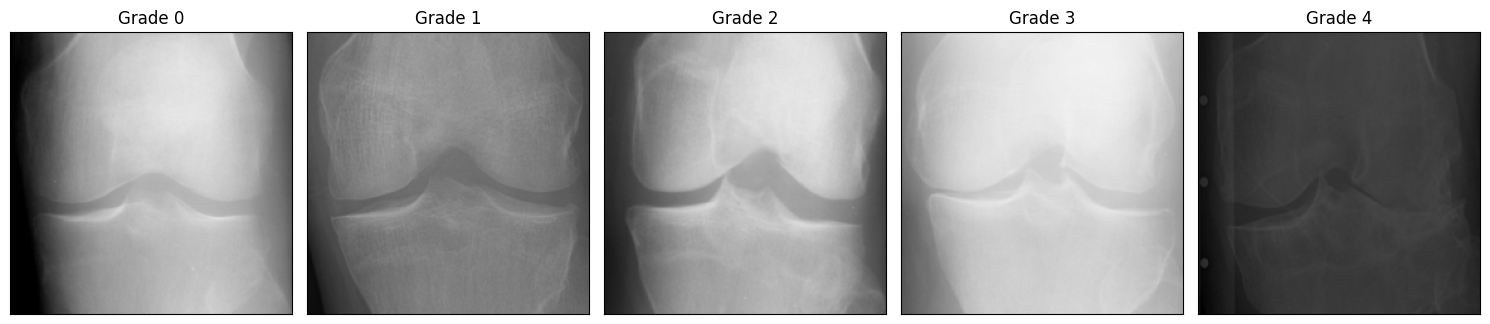

In [4]:
# Parameter for the 'side' of the knee. Possible values: L = Left | R = Right
side = 'L'

# Select 5 random images of the chosen side
selected_imgs = selectRandomImgs(side)
images = [cv2.imread(path) for path in selected_imgs]

# Create the layout to display the images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 12))
for i in range(5):
  axes[i].imshow(images[i])
  axes[i].set_title(f'Grade {i}')

# Remove axes
for ax in axes.flat:
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

Initially, the dataset contained four folders: training, test, validation, and auto_test. The *auto_test* folder included a modified version of the test images and has been removed.

In [5]:
!ls /content/KneeKL224

auto_test  test  train	val


In [ ]:
shutil.rmtree('/content/KneeKL224/auto_test')

 Each of these folders contains images categorized into the five Kellgren-Lawrence (KL) grades. There are no explicit labels provided. The grade of each image is inferred from the folder name in which the image is located.

The following code reorganizes the dataset by moving the images into a new directory structure based on their Kellgren-Lawrence grade.

In [7]:
# Creation of the main folder for the new dataset and the corresponding subfolders
os.makedirs('DatasetKneeKL', exist_ok=True)
_ = [os.makedirs(f'DatasetKneeKL/{n}', exist_ok=True) for n in range(5)]

# Moves PNG images from source directories to corresponding destination directories by grade
for grade in range(5):
  for dir in ['train', 'val', 'test']:
    path_src = f'/content/KneeKL224/{dir}/{grade}/*.png'
    path_dst = f'/content/DatasetKneeKL/{grade}/*.png'

    for img in glob.glob(path_src):
      dst_name = f'/content/DatasetKneeKL/{grade}/{os.path.basename(img)}'
      shutil.move(img, dst_name)

shutil.rmtree('/content/KneeKL224')

In [8]:
grades = countImages('/content/DatasetKneeKL/')

print(f'Total dataset cardinality: {sum(grades)}')
_ = [print(f'   Images of grade {g}: {grades[g]}') for g in range(5)]

Total dataset cardinality: 8260
   Images of grade 0: 3253
   Images of grade 1: 1495
   Images of grade 2: 2175
   Images of grade 3: 1086
   Images of grade 4: 251


The distribution of images across Kellgren-Lawrence grades is visualized using a bar chart.

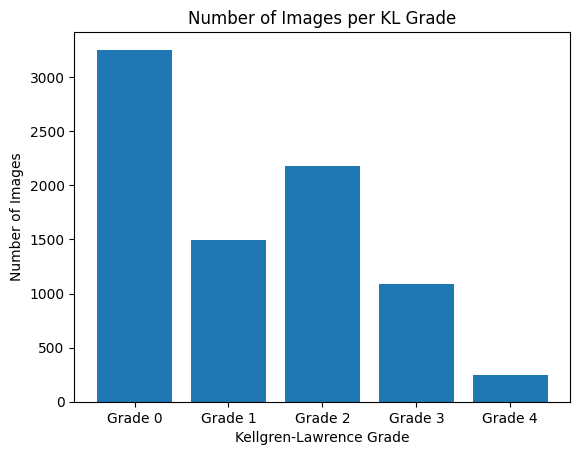

In [9]:
drawHist(grades)

### **Dataset Splitting: Train, Validation, and Test Sets**

In this section, the dataset is divided into training, validation, and test sets using functionalities provided by the *scikit-learn* library.

The dataset is split according to the following percentages:
- **Training Set**: 67.5% of the total dataset
- **Validation Set**: 22.5% of the total dataset
- **Test Set**: 10% of the total dataset


Initially, the folder structure for organizing the dataset is set up.

In [10]:
os.makedirs('KneeKL', exist_ok=True)
_ = [os.makedirs(f'KneeKL/{dir}/{grade}', exist_ok=True) for dir in ['train', 'val', 'test'] for grade in range(5)]

Indices are calculated for the initial division of the dataset into training/validation and test sets.

In [11]:
train_val_idx, test_idx = [0]*5, [0]*5
grades = countImages(f'/content/DatasetKneeKL/')

for grade in range(5):
  train_val_idx[grade], test_idx[grade] = train_test_split(
      np.arange(grades[grade]), test_size=0.1, random_state=42, shuffle=True)

The distribution of images across training/validation and test sets is displayed for each Kellgren-Lawrence grade. Images are then moved to the appropriate test set directories based on the calculated indices.

In [12]:
_ = [print(f'Immagini di grado {g}: {grades[g]:<8} | Training/Validation: {len(train_val_idx[g]):<8} | Test: {len(test_idx[g]):<8}') for g in range(5)]

_ = [moveImgs(test_idx[grade], grade, f'/content/KneeKL/test/{grade}') for grade in range(5)]

Immagini di grado 0: 3253     | Training/Validation: 2927     | Test: 326     
Immagini di grado 1: 1495     | Training/Validation: 1345     | Test: 150     
Immagini di grado 2: 2175     | Training/Validation: 1957     | Test: 218     
Immagini di grado 3: 1086     | Training/Validation: 977      | Test: 109     
Immagini di grado 4: 251      | Training/Validation: 225      | Test: 26      


The indices for dividing the remaining images into training and validation sets are calculated.

In [13]:
train_idx, val_idx = [0]*5, [0]*5
grades = countImages(f'/content/DatasetKneeKL/')

for grade in range(5):
  train_idx[grade], val_idx[grade] = train_test_split(
      np.arange(grades[grade]), test_size=0.25, random_state=42, shuffle=True)

As before, the cardinalities are displayed, and the images are moved to their respective directories. The original dataset directory is then removed.

In [14]:
_ = [print(f'Immagini di grado {g}: {grades[g]:<8} | Training: {len(train_idx[g]):<8} | Validation: {len(val_idx[g]):<8}') for g in range(5)]

_ = [moveImgs(train_idx[grade], grade, f'/content/KneeKL/train/{grade}') for grade in range(5)]
_ = [moveImgs(range(len(val_idx[grade])), grade, f'/content/KneeKL/val/{grade}') for grade in range(5)]

shutil.rmtree('/content/DatasetKneeKL', ignore_errors=True)

Immagini di grado 0: 2927     | Training: 2195     | Validation: 732     
Immagini di grado 1: 1345     | Training: 1008     | Validation: 337     
Immagini di grado 2: 1957     | Training: 1467     | Validation: 490     
Immagini di grado 3: 977      | Training: 732      | Validation: 245     
Immagini di grado 4: 225      | Training: 168      | Validation: 57      


### **Equalization**

The radiographic images in the dataset exhibited inherent limitations such as low contrast and imbalanced brightness. Histogram equalization was applied to enhance anatomical details and better highlight any potential osteoarthritis. This process used the `equalizeHist()` function from the OpenCV library after converting the images to grayscale.


Below is an example of the equalization applied to a training image.

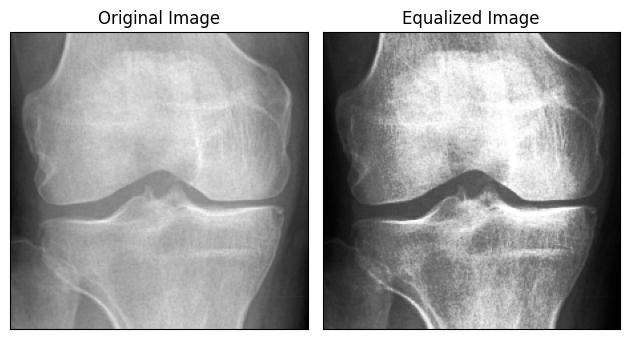

In [15]:
im1 = cv2.imread("/content/KneeKL/train/2/9022902R.png", cv2.IMREAD_GRAYSCALE)
equalized_img = cv2.equalizeHist(im1)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(im1, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(equalized_img, cmap='gray')
axes[1].set_title('Equalized Image')

# Rimozione assi
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [18]:
classes = ['0','1','2','3','4']

def equalize_images(image_directory):
  for class_name in classes:
    for image_path in glob.glob(f'{image_directory}/{class_name}/*.png'):
      grayscale_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
      equalized_image = cv2.equalizeHist(grayscale_image)
      cv2.imwrite(image_path, equalized_image)



equalize_images('/content/KneeKL/train')
equalize_images('/content/KneeKL/val')
equalize_images('/content/KneeKL/test')

### **Data Augmentation**

In this section, the process of applying data augmentation is explained. This technique is used to increase the variability of the training data, helping to reduce overfitting and improve the model's generalization.

First of all, the directory paths for the training, validation, and test datasets are set up.

In [19]:
base_dir = "/content/KneeKL/"
train_path = os.path.join(base_dir, 'train')
valid_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')

The `ImageDataGenerator` is used to apply various transformations such as horizontal flipping, brightness adjustments, width shifting, and zooming to the training set images.


In [20]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

Additionally, a separate `ImageDataGenerator` is set up without augmentation for the validation and test set, applying only the necessary preprocessing.

In [21]:
noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

Then, the data generators are set up.


In [23]:
target_size = (224, 224)

train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

test_generator = noaug_datagen.flow_from_directory(
    test_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 5570 images belonging to 5 classes.
Found 1861 images belonging to 5 classes.
Found 829 images belonging to 5 classes.


### **Class Weights**

In this section, class weights for the training dataset are computed to address class imbalance. The class frequencies are displayed, and the `compute_class_weight` function from `sklearn` is used to calculate weights for each class. These weights will be used during model training to ensure that the model is not biased towards more frequent classes.


In [24]:
from sklearn.utils.class_weight import compute_class_weight

y_train = train_generator.labels
y_val = valid_generator.labels

unique, counts = np.unique(y_train, return_counts=True)

# Compute class weights to balance the dataset
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)

train_class_weights = dict(enumerate(class_weights))

# Display the class weights
print(train_class_weights)

{0: 0.5075170842824601, 1: 1.1051587301587302, 2: 0.7593728698023177, 3: 1.5218579234972678, 4: 6.630952380952381}


## **Model Training**

In this section, a neural network model is configured and trained using TensorFlow and Keras. The model is based on a pre-trained ResNet50, with modifications made for the specific classification task.

First of all, the ResNet50 model pre-trained on ImageNet is loaded and configured for fine-tuning.

In [25]:
epochs = 125
batch_size = 32
img_shape = (224, 120, 3)

model = tf.keras.applications.ResNet50(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

94765736/94765736 [==============================] - 6s 0us/step


Then, all layers of the pre-trained ResNet50 model are set to be trainable. A new model is created by stacking the ResNet50 base with additional layers, including global average pooling, dropout for regularization, and a dense output layer with softmax activation for classification. The model architecture is then summarized.


In [26]:
for layer in model.layers:
    layer.trainable = True

model_ft = tf.keras.models.Sequential(
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation="softmax"),
    ]
)

model_ft.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 23544837 (89.82 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


The model is compiled using the **Adam** optimizer with a learning rate of **0.0001**, and the **categorical crossentropy** loss function.


In [27]:
from keras.optimizers import Adam

model_ft.compile(
    optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"]
)


Google Drive is mounted, and a callback is set up to save model weights from epoch 75 onward.

In [28]:
import os
from keras.callbacks import LambdaCallback

from google.colab import drive

# Monta Google Drive
drive.mount('/content/drive')

weights_dir = "/content/drive/MyDrive/model_weights"
os.makedirs(weights_dir, exist_ok=True)

save_weights_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: model_ft.save(os.path.join(weights_dir, f"weights_epoch_{epoch+1}.h5")) if epoch >= 75 else None
)

Mounted at /content/drive



Finally, the model is trained.

**Note**: The training process was not completed due to computational constraints.

In [ ]:
history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[save_weights_callback],
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

Epoch 1/125
175/175 [==============================] - 159s 663ms/step - loss: 1.2673 - accuracy: 0.3952 - val_loss: 2.0483 - val_accuracy: 0.4100
Epoch 2/125
175/175 [==============================] - 116s 662ms/step - loss: 0.9523 - accuracy: 0.5002 - val_loss: 1.1340 - val_accuracy: 0.5459
Epoch 3/125
175/175 [==============================] - 115s 656ms/step - loss: 0.8482 - accuracy: 0.5526 - val_loss: 1.6474 - val_accuracy: 0.3772
Epoch 4/125
175/175 [==============================] - 115s 654ms/step - loss: 0.7776 - accuracy: 0.5869 - val_loss: 0.9351 - val_accuracy: 0.6104
Epoch 5/125
175/175 [==============================] - 114s 653ms/step - loss: 0.7351 - accuracy: 0.6066 - val_loss: 1.1824 - val_accuracy: 0.3826
Epoch 6/125
175/175 [==============================] - 113s 647ms/step - loss: 0.7090 - accuracy: 0.6217 - val_loss: 2.6641 - val_accuracy: 0.2348
Epoch 7/125
175/175 [==============================] - 112s 640ms/step - loss: 0.6631 - accuracy: 0.6469 - val_loss: 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


175/175 [==============================] - 116s 663ms/step - loss: 0.0776 - accuracy: 0.9637 - val_loss: 2.1093 - val_accuracy: 0.4933
Epoch 77/125
175/175 [==============================] - 117s 670ms/step - loss: 0.0670 - accuracy: 0.9664 - val_loss: 1.9158 - val_accuracy: 0.6464
Epoch 78/125
175/175 [==============================] - 114s 652ms/step - loss: 0.0846 - accuracy: 0.9673 - val_loss: 2.3018 - val_accuracy: 0.5954
Epoch 79/125
175/175 [==============================] - 120s 683ms/step - loss: 0.1160 - accuracy: 0.9571 - val_loss: 2.1472 - val_accuracy: 0.5261
Epoch 80/125
175/175 [==============================] - 116s 662ms/step - loss: 0.0657 - accuracy: 0.9709 - val_loss: 1.8251 - val_accuracy: 0.6615
Epoch 81/125
175/175 [==============================] - 114s 653ms/step - loss: 0.0550 - accuracy: 0.9741 - val_loss: 1.6510 - val_accuracy: 0.6228
Epoch 82/125
175/175 [==============================] - 114s 648ms/step - loss: 0.0543 - accuracy: 0.9758 - val_loss: 1.9884 

## **Evaluation and Results**

In this section, the performance of the ResNet50 model is evaluated using various metrics. This includes analyzing training and validation loss and accuracy curves, test set accuracy, precision, recall, F1-score, and the confusion matrix.


The utility functions used for performance evaluation are listed below.

In [32]:
import seaborn as sns
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)

def get_evaluate(data, name, model):
    score_model = model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]:.6f}")
    print(f"{name} accuracy: {score_model[1]:.6f}")

def get_metrics(y_test, y_pred, model_name, class_names):
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc:.2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc:.2f}")
    print("\n")

    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=1, digits=5))

def compute_confusion_matrix(ytrue, ypred, class_names, model_name):
    cm = confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.subplots(figsize=(10, 8))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = matplotlib.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    resnet_model = model.get_layer('resnet50')
    last_conv_layer = resnet_model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.models.Model(resnet_model.input, last_conv_layer.output)
    classifier_input = keras.layers.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer in model.layers[1:]:
        x = layer(x)
    classifier_model = keras.models.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



Loading the model.

In [30]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/DiElle/NOTEBOOK FINALI/5CLASSI_10k/5CLASSI_10k.h5")

### **Training and Validation Loss and Accuracy Plots**

Below, the loss and accuracy graphs for the training and validation sets are shown.

**Note:** The training results were entered manually due to computational limitations during the training process.

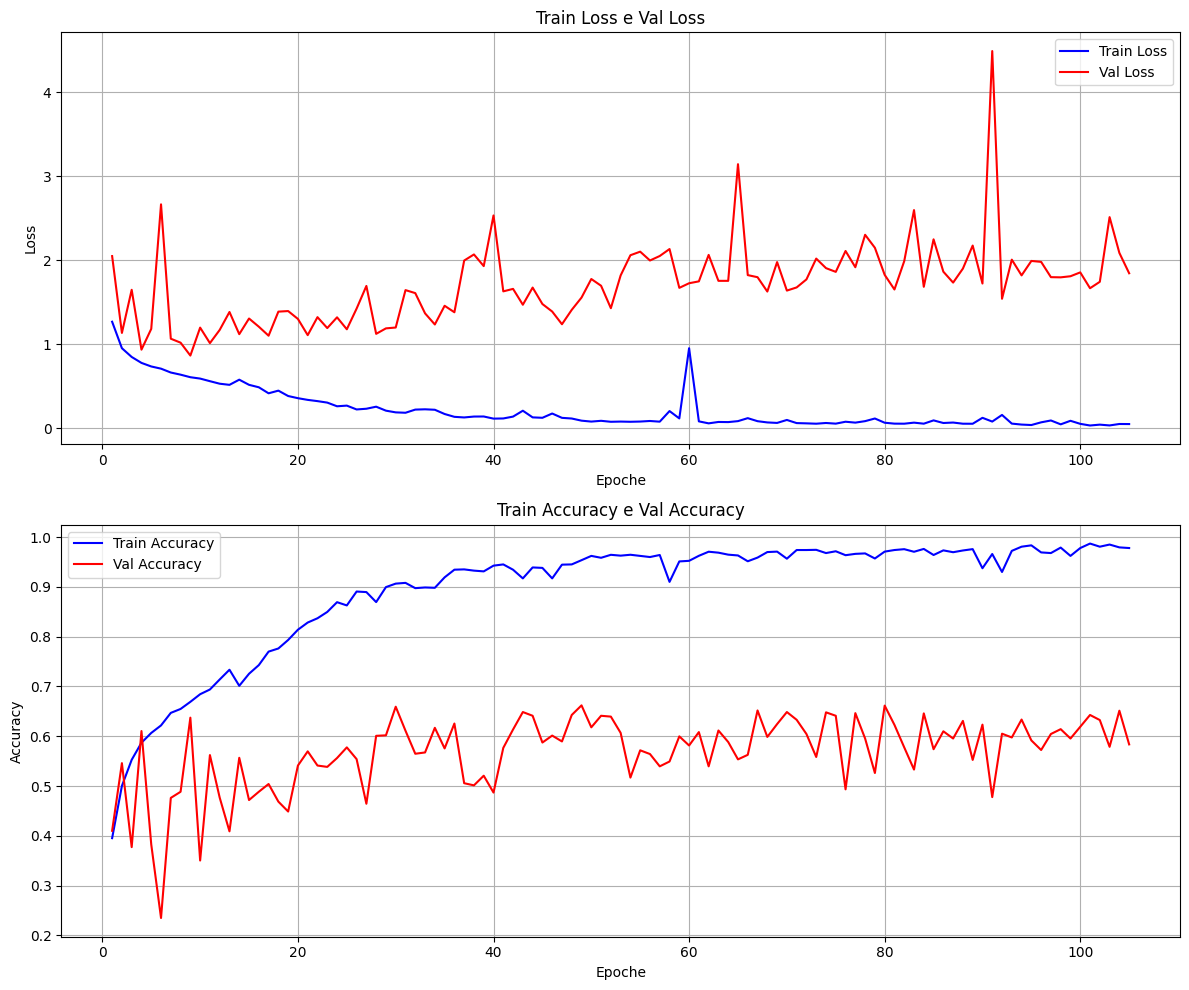

In [ ]:
# Dictionary with training data for 105 epochs
history_dict = {
    'loss': [
        1.2673, 0.9523, 0.8482, 0.7776, 0.7351, 0.7090, 0.6631, 0.6376, 0.6073, 0.5910,
        0.5600, 0.5300, 0.5165, 0.5779, 0.5167, 0.4875, 0.4158, 0.4476, 0.3836, 0.3577,
        0.3376, 0.3228, 0.3052, 0.2615, 0.2694, 0.2237, 0.2322, 0.2566, 0.2093, 0.1890,
        0.1844, 0.2220, 0.2255, 0.2201, 0.1696, 0.1359, 0.1286, 0.1392, 0.1400, 0.1146,
        0.1166, 0.1387, 0.2087, 0.1295, 0.1245, 0.1754, 0.1239, 0.1159, 0.0903, 0.0794,
        0.0886, 0.0770, 0.0795, 0.0771, 0.0798, 0.0865, 0.0784, 0.2045, 0.1170, 0.9524,
        0.0820, 0.0583, 0.0749, 0.0733, 0.0848, 0.1202, 0.0841, 0.0693, 0.0635, 0.0988,
        0.0614, 0.0583, 0.0542, 0.0627, 0.0549, 0.0776, 0.0670, 0.0846, 0.1160, 0.0657,
        0.0550, 0.0543, 0.0667, 0.0545, 0.0936, 0.0626, 0.0679, 0.0541, 0.0537, 0.1243,
        0.0796, 0.1585, 0.0553, 0.0438, 0.0384, 0.0705, 0.0925, 0.0466, 0.0888, 0.0525,
        0.0328, 0.0431, 0.0336, 0.0508, 0.0499
    ],
    'accuracy': [
        0.3952, 0.5002, 0.5526, 0.5869, 0.6066, 0.6217, 0.6469, 0.6548, 0.6691, 0.6844,
        0.6939, 0.7140, 0.7336, 0.7013, 0.7255, 0.7429, 0.7700, 0.7763, 0.7934, 0.8140,
        0.8284, 0.8370, 0.8497, 0.8693, 0.8628, 0.8907, 0.8896, 0.8695, 0.8996, 0.9066,
        0.9081, 0.8975, 0.8989, 0.8982, 0.9192, 0.9346, 0.9352, 0.9327, 0.9312, 0.9427,
        0.9452, 0.9345, 0.9171, 0.9391, 0.9382, 0.9171, 0.9447, 0.9452, 0.9537, 0.9623,
        0.9585, 0.9645, 0.9628, 0.9646, 0.9623, 0.9600, 0.9641, 0.9101, 0.9512, 0.9524,
        0.9625, 0.9707, 0.9688, 0.9648, 0.9632, 0.9515, 0.9589, 0.9700, 0.9709, 0.9567,
        0.9741, 0.9741, 0.9745, 0.9680, 0.9716, 0.9637, 0.9664, 0.9673, 0.9571, 0.9709,
        0.9741, 0.9758, 0.9706, 0.9763, 0.9641, 0.9734, 0.9697, 0.9732, 0.9759, 0.9375,
        0.9661, 0.9300, 0.9724, 0.9808, 0.9835, 0.9693, 0.9680, 0.9790, 0.9623, 0.9781,
        0.9871, 0.9808, 0.9851, 0.9794, 0.9781
    ],
    'val_loss': [
        2.0483, 1.1340, 1.6474, 0.9351, 1.1824, 2.6641, 1.0654, 1.0182, 0.8649, 1.1974,
        1.0129, 1.1700, 1.3834, 1.1194, 1.3056, 1.2083, 1.1011, 1.3875, 1.3944, 1.3005,
        1.1079, 1.3218, 1.1919, 1.3199, 1.1776, 1.4236, 1.6931, 1.1233, 1.1884, 1.1985,
        1.6436, 1.6079, 1.3670, 1.2347, 1.4573, 1.3800, 1.9954, 2.0679, 1.9292, 2.5318,
        1.6287, 1.6582, 1.4696, 1.6738, 1.4781, 1.3888, 1.2376, 1.4089, 1.5548, 1.7757,
        1.6954, 1.4284, 1.8183, 2.0587, 2.1010, 1.9960, 2.0495, 2.1322, 1.6704, 1.7253,
        1.7477, 2.0625, 1.7539, 1.7539, 3.1418, 1.8221, 1.7972, 1.6265, 1.9769, 1.6379,
        1.6756, 1.7709, 2.0185, 1.9051, 1.8606, 2.1093, 1.9158, 2.3018, 2.1472, 1.8251,
        1.6510, 1.9884, 2.5955, 1.6834, 2.2477, 1.8629, 1.7329, 1.8998, 2.1736, 1.7221,
        4.4878, 1.5407, 2.0060, 1.8189, 1.9907, 1.9796, 1.7977, 1.7955, 1.8085, 1.8545,
        1.6660, 1.7424, 2.5121, 2.0862, 1.8440
    ],
    'val_accuracy': [
        0.4100, 0.5459, 0.3772, 0.6104, 0.3826, 0.2348, 0.4761, 0.4884, 0.6373, 0.3503,
        0.5621, 0.4766, 0.4089, 0.5567, 0.4718, 0.4884, 0.5040, 0.4686, 0.4487, 0.5411,
        0.5696, 0.5411, 0.5384, 0.5562, 0.5776, 0.5540, 0.4643, 0.6008, 0.6018, 0.6593,
        0.6110, 0.5648, 0.5674, 0.6169, 0.5755, 0.6255, 0.5056, 0.5013, 0.5207, 0.4868,
        0.5766, 0.6136, 0.6486, 0.6411, 0.5873, 0.6013, 0.5895, 0.6427, 0.6620, 0.6179,
        0.6411, 0.6394, 0.6067, 0.5169, 0.5717, 0.5642, 0.5395, 0.5492, 0.5997, 0.5814,
        0.6083, 0.5395, 0.6115, 0.5884, 0.5535, 0.5626, 0.6518, 0.5986, 0.6244, 0.6486,
        0.6330, 0.6045, 0.5583, 0.6480, 0.6411, 0.4933, 0.6464, 0.5954, 0.5261, 0.6615,
        0.6228, 0.5776, 0.5330, 0.6459, 0.5739, 0.6099, 0.5954, 0.6308, 0.5524, 0.6233,
        0.4777, 0.6051, 0.5975, 0.6335, 0.5916, 0.5723, 0.6045, 0.6142, 0.5954, 0.6190,
        0.6427, 0.6325, 0.5787, 0.6513, 0.5836
    ]
}


# Extract data from history
epochs = range(1, len(history_dict['loss']) + 1)
loss = history_dict['loss']
accuracy = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_accuracy = history_dict['val_accuracy']

fig, axs = plt.subplots(2, 1, figsize=(12, 10))

axs[0].plot(epochs, loss, 'b', label='Train Loss')
axs[0].plot(epochs, val_loss, 'r', label='Val Loss')
axs[0].set_title('Train Loss and Val Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(epochs, accuracy, 'b', label='Train Accuracy')
axs[1].plot(epochs, val_accuracy, 'r', label='Val Accuracy')
axs[1].set_title('Train Accuracy and Val Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### **Test Accuracy**

Below, the test accuracy of the model is shown.

In [ ]:
get_evaluate(test_generator, "Test", model)

26/26 [==============================] - 177s 7s/step - loss: 0.5769 - accuracy: 0.8830
Test loss: 0.576920
Test accuracy: 0.882992


### **Precision, Recall and F1-score**

Below, the precision, recall, and F1 score metrics for the model are shown.

In [ ]:
# Model predictions
y_pred_proba = model.predict(test_generator)
y_pred = np.argmax(y_pred_proba, axis=1)

get_metrics(test_generator.labels, y_pred, "Test", class_names)

26/26 [==============================] - 181s 7s/step
Accuracy Score - Test: 0.88
Balanced Accuracy Score - Test: 0.90


              precision    recall  f1-score   support

           0    0.88630   0.93252   0.90882       326
           1    0.77241   0.74667   0.75932       150
           2    0.90732   0.85321   0.87943       218
           3    0.94545   0.95413   0.94977       109
           4    1.00000   1.00000   1.00000        26

    accuracy                        0.88299       829
   macro avg    0.90230   0.89730   0.89947       829
weighted avg    0.88256   0.88299   0.88229       829



### **Confusion Matrix**


Below are the two confusion matrices, shown both as percentages and in absolute values.

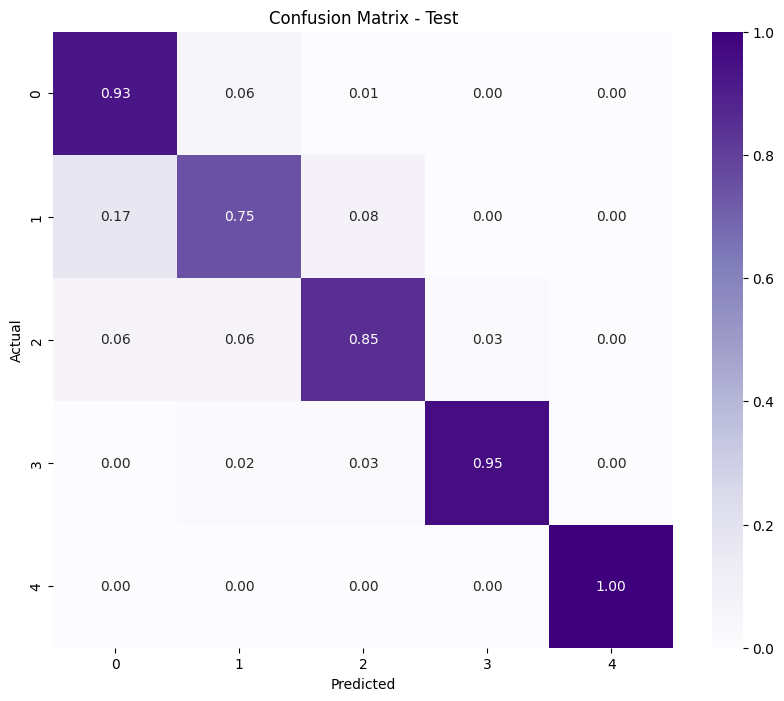

In [ ]:
compute_confusion_matrix(test_generator, y_pred_proba, class_names, "Test")

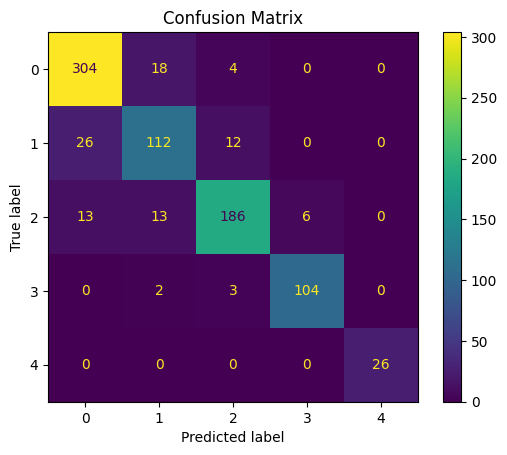

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(test_generator.labels, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["0", "1", "2", "3", "4"])

# Display confusion matrix
cmd.plot()
plt.title('Confusion Matrix')
plt.show()

### **Grad-CAM**

Below, the Grad-CAM visualization applied to a test image of grade 4.

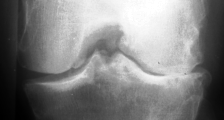

In [ ]:
img_size = (224, 224)

# Load ResNet50 preprocessing and decoding functions
preprocess_input = tf.keras.applications.resnet50.preprocess_input
decode_predictions = tf.keras.applications.resnet50.decode_predictions
last_conv_layer_name = "conv5_block3_out"

# Define the path to test images and select a random image
test_dir = "/content/KneeKL/test/4"
img_list = glob.glob(test_dir + "/*.png")
img_path = random.choice(img_list)

# Read and preprocess the image
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
equalized_img = cv2.equalizeHist(img)

# Save the processed image and display it
cv2.imwrite(img_path, equalized_img)
display(Image(img_path))

1/1 [==============================] - 2s 2s/step
Predicted: 4 with confidence 1.00


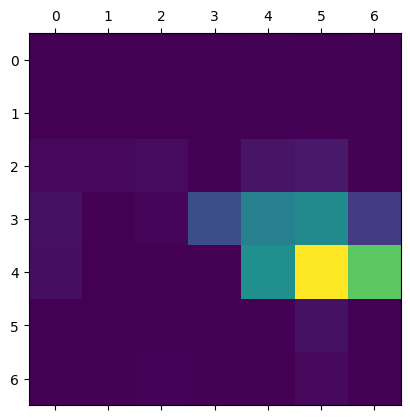

In [ ]:
# Preprocess the input image and make predictions
img_array = preprocess_input(get_img_array(img_path, size=img_size))
preds = model.predict(img_array)
class_labels = ['0', '1', '2', '3', '4']
predicted_class = class_labels[np.argmax(preds)]

# Display the predicted class and confidence
print(f"Predicted: {predicted_class} with confidence {np.max(preds):.2f}")

# Generate and display the Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()

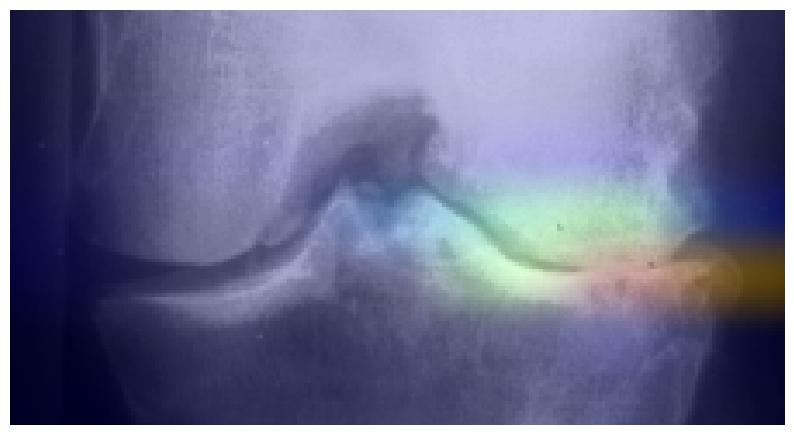

In [ ]:
save_and_display_gradcam(img_path, heatmap)